<a href="https://colab.research.google.com/github/bjkarki/MaterialsModeling/blob/master/MC_3D_StructureAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Optimized parameters were:

$$\rho = 0.5$$
$$L=6$$
$$T = \[0.2, 0.6, 1.4\]$$
print('\t nsteps for trial moves = 30,000')

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy
import time
from IPython.display import display

def siteto3D(site,L):
    """returns the index in 3D for an occupied site number"""
    z = site//(L*L)
    site2 = site - z*L*L
    x = site2//L
    y = site2%L
    return z, x, y

def init(N,L):
    """returns a list of N occupied sites and an LxLxL lattice with 0's for
       empty sites and integers >0 corresponding to non-empty sites. """
    lattice = numpy.zeros((L,L,L),dtype=numpy.int8)#Initialize empty lattice
    occupied = numpy.random.choice(L*L*L,N,replace=False)
    for i,site in enumerate(occupied):
        z, x, y = siteto3D(site,L)
        lattice[z][x][y] = i+1 #convert index on [0,V**2) to [0,V)[0,V)
    return occupied, lattice
        
def adjacent(site,L):
    """Return a tuple with indices corresponding to the six sites adjacent
       to the one passed in, wrapping around a LxL periodic volume."""
    z, x, y = siteto3D(site,L)
    zoffset = z*L*L
    xyoffset = site-zoffset
    left = ((y - 1 + L) % L) + x*L + zoffset
    right = ((y + 1) % L) + x*L + zoffset
    up =  ((x - 1 + L) % L)*L + y + zoffset
    down =  ((x + 1) % L)*L + y + zoffset
    back = ((z + L - 1)%L)*L*L + xyoffset
    front = ((z + L + 1)%L)*L*L + xyoffset
    return (right, down, front, left, up, back)
    
def energy(occupied,lattice,epsilon=-1):
    """Returns the total potential energy for the occupied sites on a lattice."""
    U = 0
    L = len(lattice)
    for site in occupied: #loop over all sites
        for neighbor in adjacent(site,L)[:3]:#Look right, down and front so we  don't double count
            z, x, y = siteto3D(neighbor,L)
            if lattice[z][x][y] != 0:
                U+=epsilon
    return U

def trial_move(occupied,lattice,T):
    """Peforms a trial move by doing the following:
        picks a particle at random, and places it randomly at an empty site
        accepts the trial move if the total potential energy is lower
        or if the energy is lower than boltzmann weight
        otherwise, rejects moves
    """
    L=len(lattice)
    V = L*L*L
    Uo = energy(occupied,lattice)
    numpy.random.shuffle(occupied) #shuffles the elements of occupied
    old = occupied[0]
    empty_mask = numpy.isin(numpy.arange(V),occupied,invert=True)
    empty_sites = numpy.arange(V)[empty_mask] # list of empty sites
    new = empty_sites[numpy.random.randint(len(empty_sites))]
    occupied[0]= new
    znew, xnew, ynew = siteto3D(new,L)
    zold, xold, yold = siteto3D(old,L)
    lattice[znew][xnew][ynew] = lattice[zold][xold][yold]
    lattice[zold][xold][yold] = 0
    Un = energy(occupied,lattice)
    if (Un<=Uo) or numpy.random.random() < numpy.exp(-(Un-Uo)/T):
        return occupied, lattice, Un
    lattice[zold][xold][yold] = lattice[znew][xnew][ynew]
    lattice[znew][xnew][ynew] = 0
    occupied[0]=old
    return occupied, lattice, Uo

def run(nsteps,T,occupied, lattice):
    """runs trial move for nsteps"""
    U = []
    for step in range(int(nsteps)):
        occupied, lattice, u = trial_move(occupied, lattice,T)
        U.append(u)
    return numpy.array(U)/len(occupied)

def analyze(data):
    """returns average and standard deviation of 1D data"""
    a = numpy.average(data)
    s = numpy.std(data)
    return a,s

def autocorr1D(array):
    '''Takes in a linear numpy array, performs autocorrelation
       function and returns normalized array with half the length 
       of the input'''
    ft = numpy.fft.rfft(array-numpy.average(array)) 
    acorr = numpy.fft.irfft(ft*numpy.conjugate(ft))/(len(array)*numpy.var(array))
    return acorr[0:len(acorr)//2]

In [0]:
##Specific heat calculation
#Simulation to obtain U for trial steps and at different temperatures
L = 6
T = numpy.arange(0.1,2.1,0.1)
results = {}
for i,temps in enumerate(T):
    occupied,lattice = init((L*L*L)//2,L)
    start = time.time()
    U = run(3e4,temps,occupied,lattice)
    stop = time.time()
    print('T = ',numpy.around(temps,decimals=2),'\t runtime = ',numpy.around(stop-start,decimals=2),' sec')
    results[i] = U

T =  0.1 	 runtime =  232.94  sec
T =  0.2 	 runtime =  230.94  sec
T =  0.3 	 runtime =  229.73  sec
T =  0.4 	 runtime =  231.21  sec
T =  0.5 	 runtime =  228.84  sec
T =  0.6 	 runtime =  232.36  sec
T =  0.7 	 runtime =  233.42  sec
T =  0.8 	 runtime =  230.29  sec
T =  0.9 	 runtime =  232.48  sec
T =  1.0 	 runtime =  231.84  sec
T =  1.1 	 runtime =  229.79  sec
T =  1.2 	 runtime =  229.92  sec
T =  1.3 	 runtime =  229.83  sec
T =  1.4 	 runtime =  230.05  sec
T =  1.5 	 runtime =  232.03  sec
T =  1.6 	 runtime =  229.53  sec
T =  1.7 	 runtime =  229.11  sec
T =  1.8 	 runtime =  230.65  sec
T =  1.9 	 runtime =  226.24  sec
T =  2.0 	 runtime =  227.74  sec


In [0]:
#Cv calculation
T = numpy.arange(0.1,2.1,0.1)
Cv = []
for i,temps in enumerate(T):
    ac = autocorr1D(results[i])
    dt = numpy.argwhere(ac<0)[0][0]
    if i==1 or i==5 or i == 13:
        print('T = ',numpy.around(temps,decimals=1),'\t dt = ',dt)
    #print('No of independent samples, for T = {:0.1f} is {}'.format(T[i],len(results[i])//dt + 1))
    U1 = results[i][::-dt] #independent sampling from the end
    U2 = results[i][::dt] #independent sampling from the beginning
    c1 = (1/temps**2)*numpy.var(U1)
    c2 = (1/temps**2)*numpy.var(U2)
    Cv.append((c1,c2))

T =  0.2 	 dt =  3431
T =  0.6 	 dt =  4744
T =  1.4 	 dt =  417


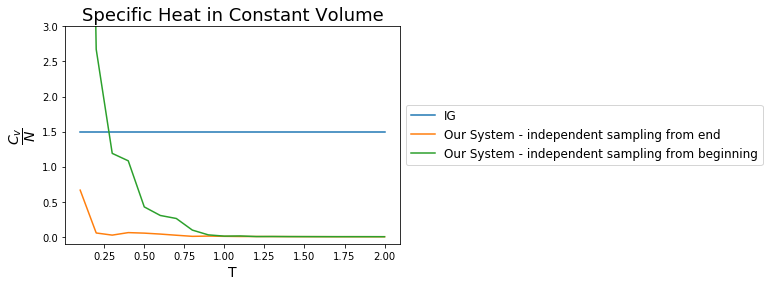

Since our potential interaction is U = -1 for neighbouring particle,
	it makes sense that Cv approaches 0, because U is independent of temperature.


In [0]:
#Plot Cv
#Cv of our system
Cv = numpy.array(Cv)
#Cv of IG
CvIG = 3/2;
CvIG = numpy.repeat(CvIG,len(T))
plt.plot(T,CvIG)
plt.plot(T,Cv[:,0])
plt.plot(T,Cv[:,1])
plt.ylim([-0.1, 3])
plt.xlabel('T',fontsize=14)
plt.ylabel(r'$\dfrac{C_v}{N}$',fontsize=14)
plt.legend(['IG','Our System - independent sampling from end','Our System - independent sampling from beginning'],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.title('Specific Heat in Constant Volume', fontsize=18)
plt.show()

print('Since our potential interaction is U = -1 for neighbouring particle,\n\tit makes sense that Cv approaches 0, because U is independent of temperature.')

In [0]:
###Updated functions and new functions for rdf calculation

#Updated run file to obtain config
def run(nsteps,T,occupied, lattice):
    """runs trial move for nsteps"""
    U = []
    config = []
    writeTime = 5000
    #maximum no of steps before independent sampling was 4744 for T = 0.6
    for step in range(int(nsteps)):
        occupied, lattice, u = trial_move(occupied, lattice,T)
        if step%writeTime==0:
            config.append(numpy.array(occupied))
        U.append(u)
    return numpy.array(U)/len(occupied),numpy.array(config)

#Periodic boundary condition function that helps calculate correct distance
def pbc(d,L):
    return d - L * ((d+L/2)//L)

#rdf function
def rdf(coords,L,dr):
    rmax = L/2
    nbins = int(rmax//dr)
    r = numpy.array([i*dr for i in range(nbins)])    
    bins = numpy.zeros(nbins)
    for i,a in enumerate(coords[:-1]):#all but the last
        for b in coords[i+1:]:
            delta = b-a
            for h in range(3):
                delta[h] = pbc(delta[h],L)
            d = numpy.absolute(numpy.linalg.norm(delta))
            index = int(d//dr)
            if index<nbins:
                bins[index] += 1 
    for i, b in enumerate(bins):
        bins[i] /= (N*(N-1)/2)*numpy.pi*(4*numpy.square(dr*(i+1))*dr)/V #normalize by volume of annulus AND number of pairs
    #Note: Number of Pairs is N*(N-1)/2 (Sum of numbers from 1 to N-1)    
        
    return r, bins

In [0]:
L = 6
T = [0.2, 0.6, 1.4]
results = {}
for temps in T:
    occupied,lattice = init((L*L*L)//2,L)
    start = time.time()
    U,config = run(3e4,temps,occupied,lattice)
    stop = time.time()
    print('T = ',numpy.around(temps,decimals=2),\
      '\t runtime = ',numpy.around(stop-start,decimals=2),'sec',\
      '\tU = ', numpy.around(numpy.average(U),decimals=2),\
      '+/-', numpy.around(numpy.std(U),decimals=2))
    results[temps]=numpy.array(config)

T =  0.2 	 runtime =  176.25 sec 	U =  -2.58 +/- 0.14
T =  0.6 	 runtime =  175.81 sec 	U =  -2.35 +/- 0.11
T =  1.4 	 runtime =  175.64 sec 	U =  -1.78 +/- 0.07


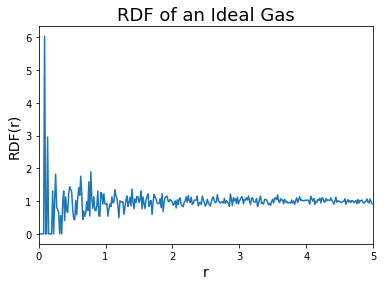

Hurray! RDF function works, based on the results for IG.


In [0]:
###First check my rdf for IG
N = 400 
L = 10
Lmin=-L/2
Lmax = L/2
V = L*L*L
coords=numpy.random.uniform(low=Lmin, high=Lmax, size=(N,3))
dr = 0.015
r,bins = rdf(coords, L, dr)
plt.plot(r,bins)
plt.xlim([0,Lmax])
plt.xlabel('r',fontsize=14)
plt.ylabel('RDF(r)',fontsize=14)
plt.title('RDF of an Ideal Gas',fontsize=18)
plt.show()
print('Hurray! RDF function works, based on the results for IG.')

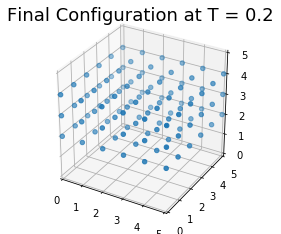

In [0]:
# Plot the last configuration at T = 0.2
L = 6
occupied = results[0.2][-1]
coords = [];
for site in occupied:
    z,x,y = siteto3D(site,L)
    coords.append((x,y,z))
coords = numpy.array(coords)
ax = plt.axes(projection='3d')
ax.scatter3D(coords[:,0],coords[:,1],coords[:,2])
ax.set_xlim3d(0, L-1)
ax.set_ylim3d(0, L-1)
ax.set_zlim3d(0, L-1)
ax.set_aspect("equal")
plt.title('Final Configuration at T = 0.2',fontsize=18)
plt.show()

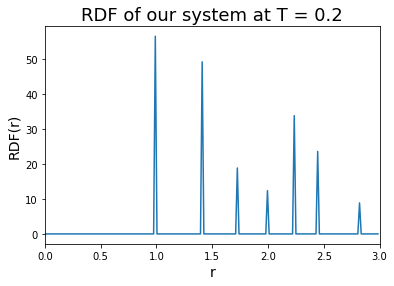

This plot makes sense as the particles can only occupy lattice sites.
Thus we have discrete peaks.
By looking at this plot, I guess we can predict the crystal structure from this plot, but I am not sure.


In [0]:
#Plot the RDF for our system at T = 0.2
L = 6
Lmax = L/2
Lmin = -L/2
V = L*L*L
N = V//2
dr = 0.015
r,bins = rdf(coords, L, dr)
plt.plot(r,bins)
plt.xlim([0,Lmax])
plt.xlabel('r',fontsize=14)
plt.ylabel('RDF(r)',fontsize=14)
plt.title('RDF of our system at T = 0.2',fontsize=18)
plt.show()
print('This plot makes sense as the particles can only occupy lattice sites.\
\nThus we have discrete peaks.\
\nBy looking at this plot, I guess we can predict the crystal structure from this plot, but I am not sure.')

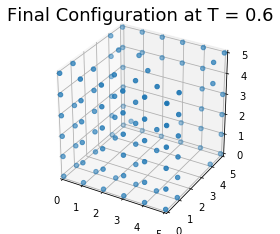

In [0]:
# Plot the last configuration at T = 0.6
L = 6
occupied = results[0.6][-1]
coords = [];
for site in occupied:
    z,x,y = siteto3D(site,L)
    coords.append((x,y,z))
coords = numpy.array(coords)
ax = plt.axes(projection='3d')
ax.scatter3D(coords[:,0],coords[:,1],coords[:,2])
ax.set_xlim3d(0, L-1)
ax.set_ylim3d(0, L-1)
ax.set_zlim3d(0, L-1)
ax.set_aspect("equal")
plt.title('Final Configuration at T = 0.6',fontsize=18)
plt.show()

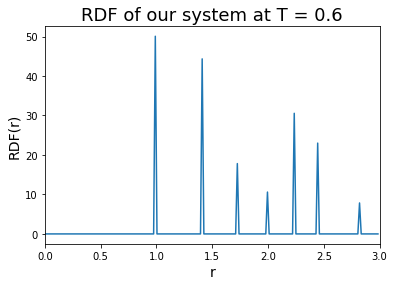

In [0]:
#Plot the RDF for our system at T = 0.6
L = 6
Lmax = L/2
Lmin = -L/2
V = L*L*L
N = V//2
dr = 0.015
r,bins = rdf(coords, L, dr)
plt.plot(r,bins)
plt.xlim([0,Lmax])
plt.xlabel('r',fontsize=14)
plt.ylabel('RDF(r)',fontsize=14)
plt.title('RDF of our system at T = 0.6',fontsize=18)
plt.show()

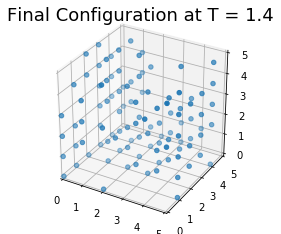

In [0]:
# Plot the last configuration at T = 1.4
L = 6
occupied = results[1.4][-1]
coords = [];
for site in occupied:
    z,x,y = siteto3D(site,L)
    coords.append((x,y,z))
coords = numpy.array(coords)
ax = plt.axes(projection='3d')
ax.scatter3D(coords[:,0],coords[:,1],coords[:,2])
ax.set_xlim3d(0, L-1)
ax.set_ylim3d(0, L-1)
ax.set_zlim3d(0, L-1)
ax.set_aspect("equal")
plt.title('Final Configuration at T = 1.4',fontsize=18)
plt.show()

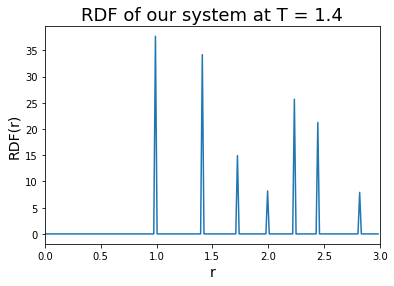

In [0]:
#Plot the RDF for our system at T = 1.4
L = 6
Lmax = L/2
Lmin = -L/2
V = L*L*L
N = V//2
dr = 0.015
r,bins = rdf(coords, L, dr)
plt.plot(r,bins)
plt.xlim([0,Lmax])
plt.xlabel('r',fontsize=14)
plt.ylabel('RDF(r)',fontsize=14)
plt.title('RDF of our system at T = 1.4',fontsize=18)
plt.show()

In [0]:
print('I was expecting the RDF to change as Temperature changes.\
\nFrom the U vs T plot, I specifially chose T at 3 different behavior\
\n(Please check the Parameter Optimization notebook)\
\nBased on the results, my prediction was wrong.\
\nThe RDF looks identical at 3 different temperature regions')

I was expecting the RDF to change as Temperature changes.
From the U vs T plot, I specifially chose T at 3 different behavior
(Please check the Parameter Optimization notebook)
Based on the results, my prediction was wrong.
The RDF looks identical at 3 different temperature regions


In [0]:
print('I was unable to calculate the Equation of state for my system')

I was unable to calculate the Equation of state for my system


In [0]:
###To save data structure created in our simulations
#import pickle

#saving dict file
#pickle_out = open("result_for_rdf.pickle","wb")
#pickle.dump(results, pickle_out)
#pickle_out.close()

#loading dict file
#pickle_in = open("U.pickle","rb")
#results = pickle.load(pickle_in)